In [13]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile
import os
import PythonMeta as PMA
from rpy2.robjects import r
from pretty_html_table import build_table
from pdf2image import convert_from_path
import base64
from PIL import Image
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [14]:
#my_zip = zipfile.ZipFile('./test_data/DCMC.zip')

inpath ='./test_data'
sources = [i.split('.zip')[0] for i in os.listdir(inpath) if i.endswith('.zip')]

In [43]:
negative_dict, results_dict, covariate_dict, km_dict, attrition_dict, ps_dict= {}, {}, {}, {}, {}, {}

for source in sources:
    my_zip= zipfile.ZipFile(os.path.join(inpath, f'{source}.zip'))
    negative_path=[i for i in my_zip.namelist() if i.endswith('negative_control_outcome.csv')][0]
    covariate_path=[i for i in my_zip.namelist() if i.endswith('covariate_balance.csv')][0]
    km_path=[i for i in my_zip.namelist() if i.endswith('kaplan_meier_dist.csv')][0]
    method_result_path=[i for i in my_zip.namelist() if i.endswith('cohort_method_result.csv')][0]
    attrition_path=[i for i in my_zip.namelist() if i.endswith('attrition.csv')][0]
    ps_path = [i for i in my_zip.namelist() if i.endswith('preference_score_dist.csv')][0]

    negative_outcome = pd.read_csv(my_zip.open(negative_path))
    cohort_results = pd.read_csv(my_zip.open(method_result_path))
    cohort_results['source'] = source
    covariate_balance = pd.read_csv(my_zip.open(covariate_path))
    km_dist = pd.read_csv(my_zip.open(km_path))
    attrition = pd.read_csv(my_zip.open(attrition_path))
    attrition['source']= source
    attrition['cohort']=attrition.apply(lambda x : 'target' if x['exposure_id']==x['target_id'] else 'comparator', axis=1)
    ps_dist = pd.read_csv(my_zip.open(ps_path))
 
    negative_dict[source] = negative_outcome
    results_dict[source] = cohort_results.round(3)
    covariate_dict[source] = covariate_balance
    km_dict[source] = km_dist
    attrition_dict[source] = attrition
    ps_dict[source] = ps_dist

negative_ids=list(negative_dict.values())[0].outcome_id
results_cated=pd.concat(results_dict.values())
required_cols=['source', 'target_id', 'comparator_id', 'outcome_id','rr','ci_95_lb','ci_95_ub','p','target_subjects',
               'comparator_subjects','target_outcomes','comparator_outcomes']
results=results_cated[~results_cated['outcome_id'].isin(negative_ids)][required_cols]

negative_cated=results_cated[results_cated['outcome_id'].isin(negative_ids)]
negatives=pd.DataFrame(negative_cated[required_cols].dropna(subset=['rr']).query('p>0.05').groupby('source').count()['rr'])
negatives.columns=['Negative outcomes']
negatives['Non-signifcant percent']=negatives['Negative outcomes']/len(negative_ids) * 100 

attrition_cated = pd.concat(attrition_dict.values())
attritions =attrition_cated.pivot(index=['source','cohort',],columns='description',values='subjects')

results.to_csv('./results/temp_results.csv') # TODO : 여기에서 args로 새로운값 추가가능하도록 고침
negative_cated.to_csv('./results/temp_negatives.csv')

r('''
library(metafor)
tt= read.csv('./results/temp_results.csv')
data1= escalc(measure='RR',ai=target_outcomes, bi=target_subjects, ci=comparator_outcomes, di=comparator_subjects, data=tt, append=TRUE)
res1 <- rma(yi, vi, data = data1, digits = 3)
res2 <- rma(yi, vi, data=data1, digits=3, method="FE")

pdf(file='./results/forest_random.pdf')
forest(res1, atransf=exp, at=log(c(.05, .25, 1, 4)), xlim=c(-16,6),
       ilab=cbind(target_outcomes, target_subjects, comparator_outcomes, comparator_subjects), ilab.xpos=c(-9.5,-8,-6,-4.5), 
       cex=.75, header="Hospital", mlab="",slab=(source))
text(-16, -1, pos=4, cex=0.75, bquote(paste("Random Model (Q = ",
                                            .(formatC(res$QE, digits=2, format="f")), ", df = ", .(res$k - res$p),
                                            ", p = ", .(formatC(res$QEp, digits=2, format="f")), "; ", I^2, " = ",
                                            .(formatC(res$I2, digits=1, format="f")), "%)")))
dev.off()

pdf(file='./results/forest_fixed.pdf')
forest(res2, atransf=exp, at=log(c(.05, .25, 1, 4)), xlim=c(-16,6),
       ilab=cbind(target_outcomes, target_subjects, comparator_outcomes, comparator_subjects), ilab.xpos=c(-9.5,-8,-6,-4.5), 
       cex=.75, header="Hospital", mlab="",slab=(source))
text(-16, -1, pos=4, cex=0.75, bquote(paste("Fixed Model (Q = ",
                                            .(formatC(res$QE, digits=2, format="f")), ", df = ", .(res$k - res$p),
                                            ", p = ", .(formatC(res$QEp, digits=2, format="f")), "; ", I^2, " = ",
                                            .(formatC(res$I2, digits=1, format="f")), "%)")))
dev.off()
''')


NotImplementedError: Conversion 'rpy2py' not defined for objects of type '<class 'rpy2.rinterface.SexpClosure'>'

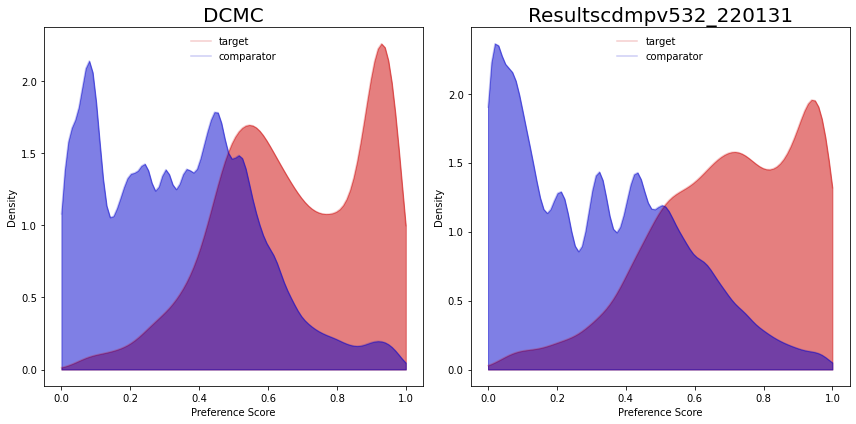

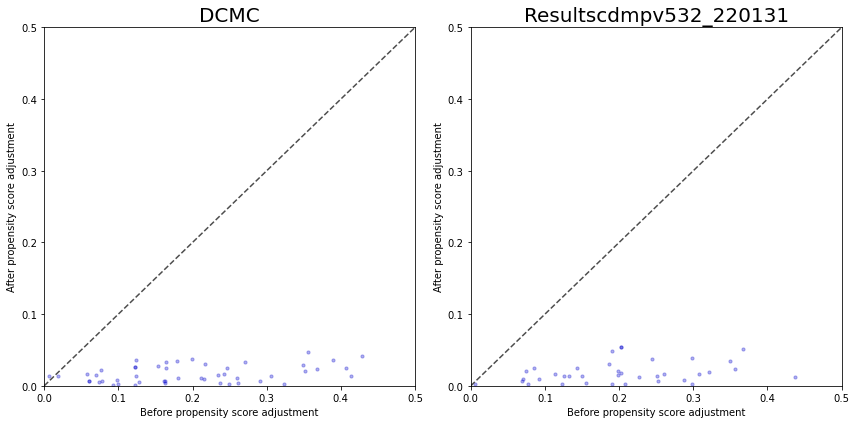

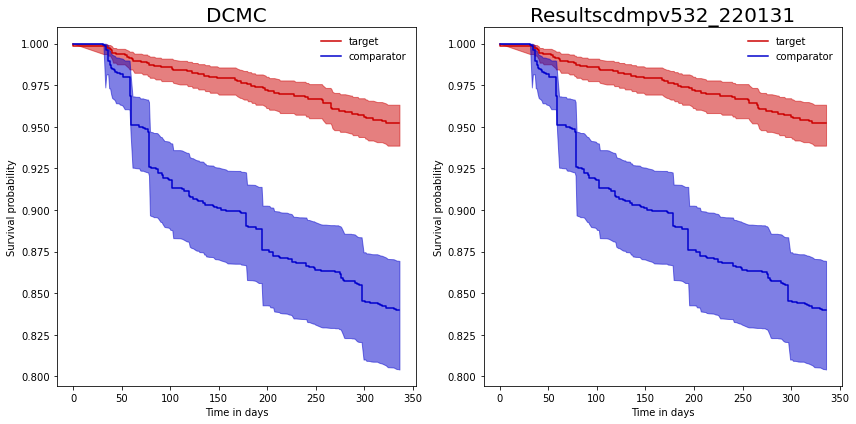

In [16]:
###
fig1, axes= plt.subplots(max(len(sources)//2,1),2, figsize=(12,3 * len(sources)),facecolor='white')
for num, source in enumerate(sources):
    ps_score=ps_dict[source]
    coord = (num//2, num%2) if num // 2> 1 else num%2
    axes[coord].plot(ps_score['preference_score'],ps_score['target_density'], color=(0.8, 0, 0),alpha=0.2, label='target')
    axes[coord].plot(ps_score['preference_score'],ps_score['comparator_density'], color=(0, 0, 0.8),alpha=0.2, label='comparator')
    axes[coord].fill_between(ps_score['preference_score'],0,ps_score['target_density'], color=(0.8, 0, 0),alpha=0.5, )
    axes[coord].fill_between(ps_score['preference_score'],0,ps_score['comparator_density'], color=(0, 0, 0.8),alpha=0.5, )
    axes[coord].set_xlabel('Preference Score')
    axes[coord].set_ylabel('Density')
    axes[coord].legend(loc='upper center',frameon=False)
    axes[coord].set_title(source, size=20)
fig1.tight_layout()
fig1.savefig('./results/ps_density.png',dpi=100)

#####
fig2, axes= plt.subplots(max(len(sources)//2,1),2, figsize=(12,3 * len(sources)),facecolor='white')
for num, source in enumerate(sources):
    coord = (num//2, num%2) if num // 2> 1 else num%2
    cov_bal=covariate_dict[source]
    cov_bal['std_diff_after_abs']=cov_bal['std_diff_after'].map(lambda x : abs(x))
    cov_bal['std_diff_before_abs']=cov_bal['std_diff_before'].map(lambda x : abs(x))
    axes[coord].set_xlabel('Before propensity score adjustment')
    axes[coord].set_ylabel('After propensity score adjustment')
    axes[coord].scatter(cov_bal['std_diff_before_abs'],cov_bal['std_diff_after_abs'], color=(0, 0, 0.8), alpha = 0.3, s=10)
    axes[coord].set_xlim(0,0.5)
    axes[coord].set_ylim(0,0.5)
    axes[coord].plot([0,1], linestyle='--', color=(0.3, 0.3, 0.3))
    axes[coord].set_title(source, size=20)
fig2.tight_layout()
fig2.savefig('./results/cov_bal.png',dpi=100)

####
fig3, axes= plt.subplots(max(len(sources)//2,1),2, figsize=(12,3 * len(sources)),facecolor='white')
for num, source in enumerate(sources):
    coord = (num//2, num%2) if num // 2> 1 else num%2
    cov_bal=km_dict[source]
    axes[coord].step(km_dist['time'], km_dist['target_survival'], color = (0.8, 0, 0), label='target')
    axes[coord].fill_between(km_dist['time'],km_dist['target_survival_lb'],km_dist['target_survival_ub'], color=(0.8, 0, 0),alpha=0.5, )
    axes[coord].step(km_dist['time'], km_dist['comparator_survival'],color=( 0, 0,0.8), label='comparator')
    axes[coord].fill_between(km_dist['time'],km_dist['comparator_survival_ub'],km_dist['comparator_survival_lb'], color=( 0, 0,0.8),alpha=0.5, )
    axes[coord].set_xlabel('Time in days')
    axes[coord].set_ylabel('Survival probability')
    axes[coord].legend(frameon=False)
    axes[coord].set_title(source, size=20)
fig3.tight_layout()
fig3.savefig('./results/km_plot.png',dpi=100)

###
fig4, axes= plt.subplots(1,2, figsize=(30,15),facecolor='white')
img1=Image.open('./results/forest_fixed.png')
axes[0].imshow(img1)
axes[0].axis('off')

img2=Image.open('./results/forest_random.png')
axes[1].imshow(img2)
axes[1].axis('off')
fig4.tight_layout()
fig4.savefig('./results/forest_plot.png',dpi=100)

In [ ]:
page_title_text='My report'
title_text = 'PLE'
text = ','.join(sources) + ' are included in the analysis.'
results_text = 'Estimation summary'
negative_text = 'Negative outcomes'
attrition_text = 'Attritions'
stats_text = 'Historical prices summary statistics'


aa=attritions.reset_index()
aa.columns = list(aa.columns)

forest_fixed_uri = base64.b64encode(open('./results/forest_fixed.png', 'rb').read()).decode('utf-8')
forest_random_uri = base64.b64encode(open('./results/forest_random.png', 'rb').read()).decode('utf-8')
forest_plot_uri = base64.b64encode(open('./results/forest_plot.png', 'rb').read()).decode('utf-8')
ps_density_uri = base64.b64encode(open('./results/ps_density.png', 'rb').read()).decode('utf-8')
cov_bal_uri= base64.b64encode(open('./results/cov_bal.png', 'rb').read()).decode('utf-8')
km_plot_uri = base64.b64encode(open('./results/km_plot.png', 'rb').read()).decode('utf-8')

# 2. Combine them together using a long f-string
html = f'''
    <html>
        <head>
            <title>{page_title_text}</title>
        </head>
        <body>
            <h1>{title_text}</h1>
            <p>{text}</p>
            
            <h2>{results_text}</h2>
            {build_table(results, 'blue_light')}
            <h2>Forest plot</h2>
            <img src="data:image/png;base64,{forest_plot_uri}" width="1100"> 
            
            <h2>{attrition_text}</h2>
            {build_table(aa, 'green_light')}
            
            <h2>PS distribution</h2>
            <img src="data:image/png;base64,{ps_density_uri}" width="1100">
            
            <h2>Covariate balance</h2>
            <img src="data:image/png;base64,{cov_bal_uri}" width="1100">
            
            <h2>Kaplan-Meier curve</h2>
            <img src="data:image/png;base64,{km_plot_uri}" width="1100">

        </body>
    </html>
    '''
    
# 3. Write the html string as an HTML file
with open('html_report.html', 'w') as f:
    f.write(html)

In [10]:
fpdf=FPDF()
fpdf.add_page()
fpdf.image('./results/km_plot.png',x=10,y=8,w=190)
fpdf.output('./results/results.pdf')

''

In [44]:
convert_from_path('./results/forest_fixed.pdf')[0].save('./results/forest_fixed.png','PNG',dpi=500)

PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file './results/forest_fixed.pdf': No such file or directory.


In [26]:
axes[0].imshow()

AttributeError: imshow

In [25]:
axes[0].imshow(pages[0])

AttributeError: imshow

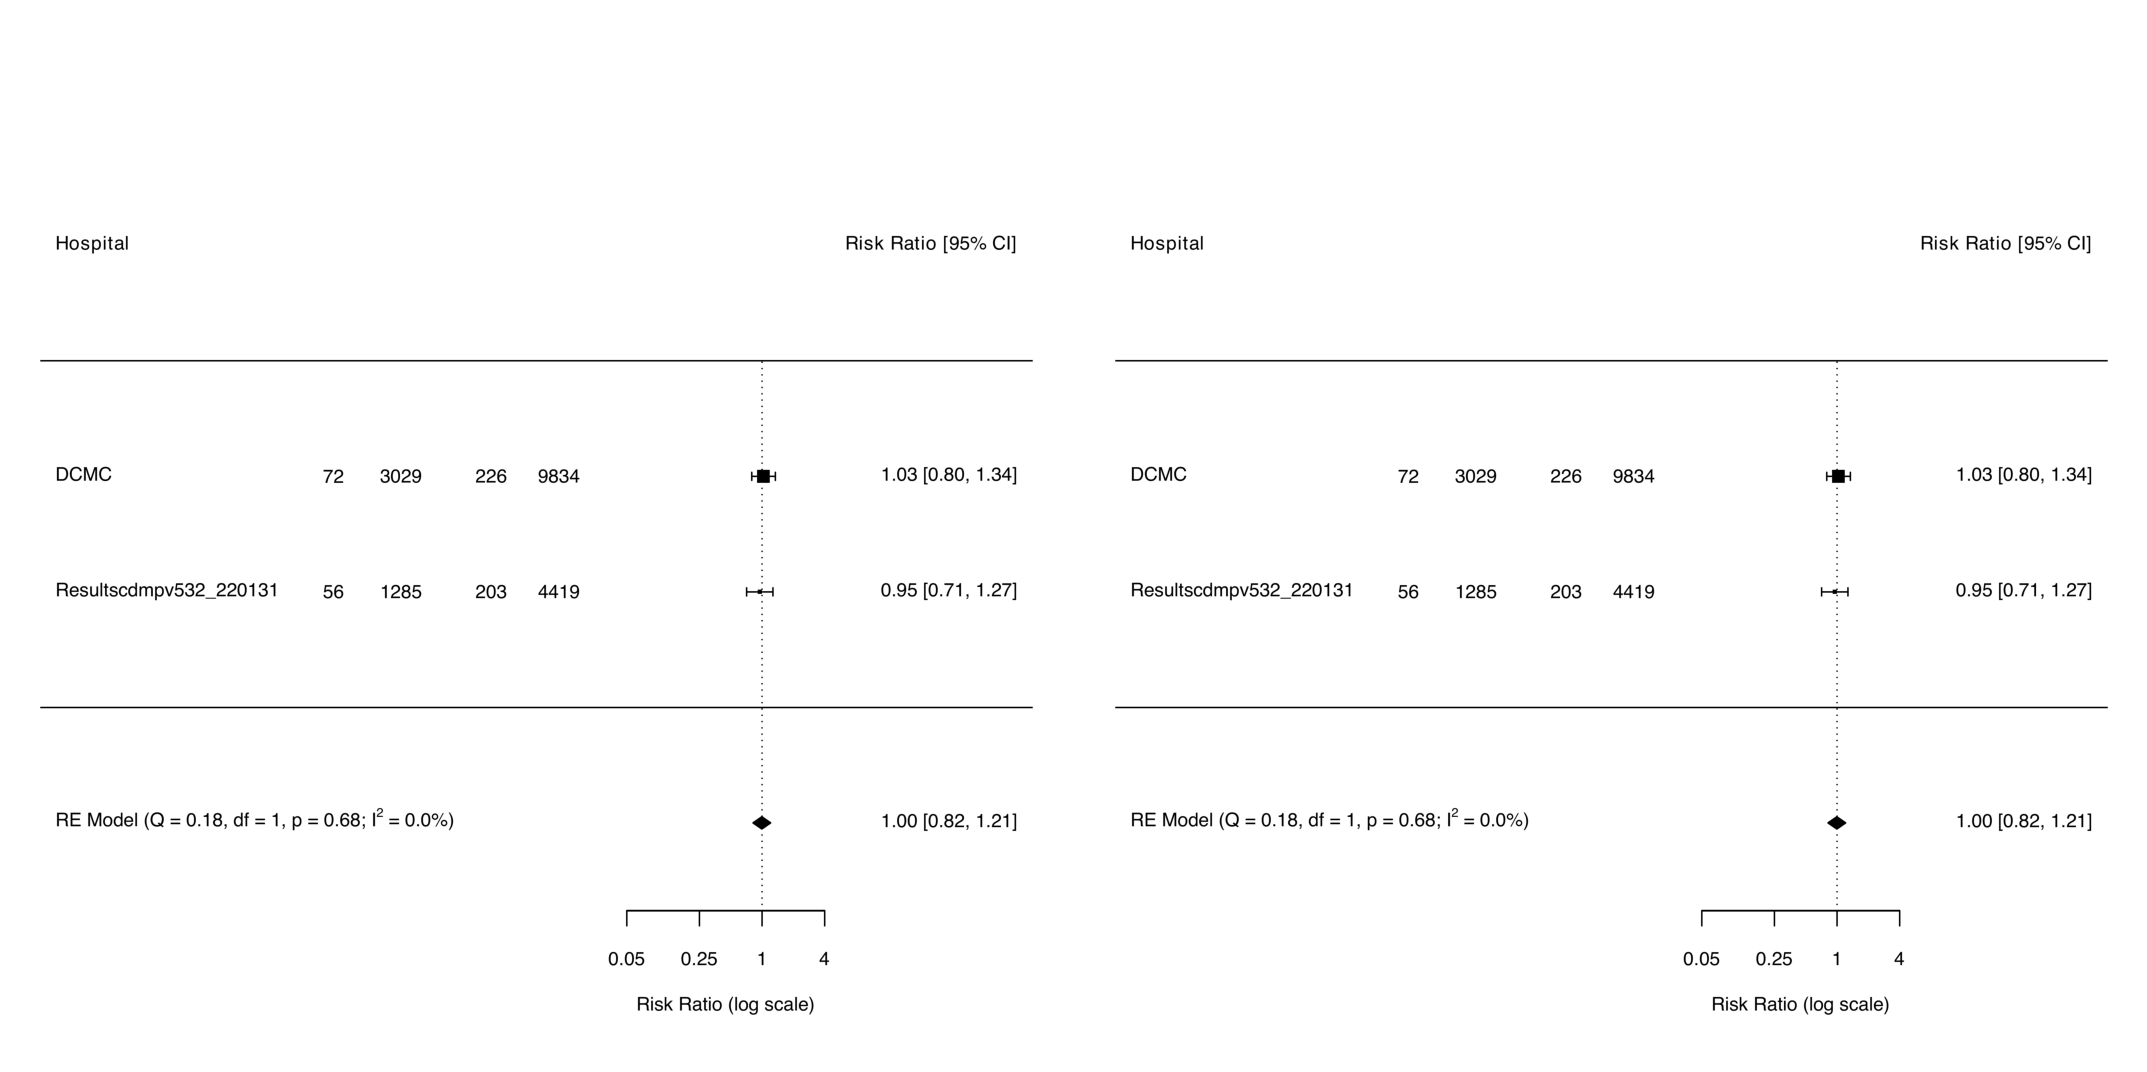

RuntimeError: FPDF error: Unsupported image type: pdf

In [484]:
import matplotlib
import seaborn as sns

def save_df_as_image(df, path):
    # Set background to white
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "white"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    # Make plot
    plot = sns.heatmap(df, annot=True, cmap=cmap, cbar=False)
    fig = plot.get_figure()
    fig.savefig(path)
save_df_as_image(results, 'results_table.png')

ValueError: could not convert string to float: 'DCMC'

In [482]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import dataframe_image as dfi
dfi.export(results, 'results_table.png')

NameError: name 'dfi' is not defined

In [477]:
page_title_text='My report'
title_text = 'PLE'
text = 'Hello, welcome to your report!'
results_text = 'Estimation summary'
negative_text = 'Negative outcomes'
attrition_text = 'Attritions'
stats_text = 'Historical prices summary statistics'

# 2. Combine them together using a long f-string
html = f'''
    <html>
        <head>
            <title>{page_title_text}</title>
        </head>
        <body>
            <h1>{title_text}</h1>
            <p>{text}</p>

            <h2>{results_text}</h2>
            {build_table(results, 'blue_light')}
            <h2>{attrition_text}</h2>
            {attritions.to_html()}
            <h2>PS distribution</h2>
            <img src='ps_density.png' width="700">
            <h2>Covariate balance</h2>
            <img src='cov_bal.png' width="700">
            <h2>Kaplan-Meier curve</h2>
            <img src='km_plot.png' width="700">

        </body>
    </html>
    '''
    
# 3. Write the html string as an HTML file
with open('html_report.html', 'w') as f:
    f.write(html)

KeyboardInterrupt: 

''

In [ ]:
import numpy as np
df=negative_cated.dropna(subset=['rr']).query('source == "DCMC" ' )
fig4, axes= plt.subplots(1,1,facecolor='white', figsize=(6,3))
axes.set_xlabel('Hazard ratio')
axes.set_ylabel('Standard Error')
axes.set_xlim(0.1,10)
axes.set_ylim(0,1.1)

axes.axvline(1, color='black', alpha=0.5)
axes.scatter(df['rr'],df['se_log_rr'], color=(0, 0, 0.8), alpha = 0.3, s=10)
axes.plot([1,10], [0,1/1.96], linestyle='--', color=(0.3, 0,0))
axes.plot([0.1,1], [1/1.96 ,0], linestyle='--', color=(0.3, 0,0))
axes.set_xscale('log')